# Speech Emotion Model

---



---

---



---



---



---





## This code has been documented and visualized by me to make it easier to understand.

## _______________________________________________________________

## Importing the necessary Libraries

In [0]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import wave
import pylab
import IPython.display as ipd
import numpy as np
import pandas as pd

import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import json
import tensorflow as tf
import pandas as pd
import glob 
import os
import pickle
import seaborn as sns

## This next step is only necessary if you are training your model on Google Colab

## You need to mount the drive and change into a directory where the "meld" folder is

In [2]:
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# cd drive/My\ Drive

/content/drive/My Drive


In [4]:
# cd Emotions/

/content/drive/My Drive/Emotions


## After doing that, we can use th OS to go through each folder and find the number of files in each of them.
## This will give us the basic idea of how big is the training and the testing set

### Next up, we will just look at the number of files in train and test folder

In [5]:
disgust = os.listdir('./meld/train/disgust/')
disgust_length = len(disgust)

fear = os.listdir('./meld/train/fear/')
fear_length = len(fear)

happy = os.listdir('./meld/train/happy/')
happy_length = len(happy)

neutral = os.listdir('./meld/train/neutral/')
neutral_length = len(neutral)

sad = os.listdir('./meld/train/sad/')
sad_length = len(sad)

print("neutral: ", neutral_length)
print("sad: ", sad_length)
print("disgust: ", disgust_length)
print("happy: ", happy_length)
print("fear: ", fear_length)

neutral:  4600
sad:  705
disgust:  232
happy:  1609
fear:  216


In [6]:
disgust = os.listdir('./meld/val/disgust/')
disgust_length = len(disgust)

fear = os.listdir('./meld/val/fear/')
fear_length = len(fear)

happy = os.listdir('./meld/val/happy/')
happy_length = len(happy)

neutral = os.listdir('./meld/val/neutral/')
neutral_length = len(neutral)

sad = os.listdir('./meld/val/sad/')
sad_length = len(sad)

print("neutral: ", neutral_length)
print("sad: ", sad_length)
print("disgust: ", disgust_length)
print("happy: ", happy_length)
print("fear: ", fear_length)

neutral:  517
sad:  79
disgust:  28
happy:  181
fear:  25


### Lets look at the waveplot of a random file.
### You can look at the waveplot of any file by changing the path to the location of that file

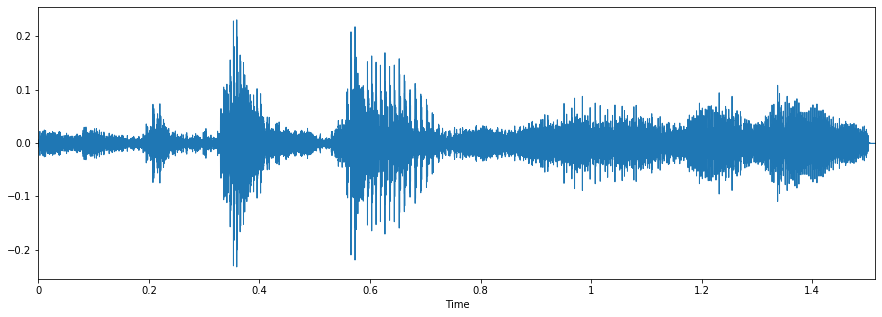

In [7]:
path = './meld/train/happy/MEL_dia1001_utt10_positive_HAP.wav'
data, sampling_rate = librosa.load(path)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
ipd.Audio(path)

### Once we take a look at the waveplot, we can now plot the spectogram of any audio file

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


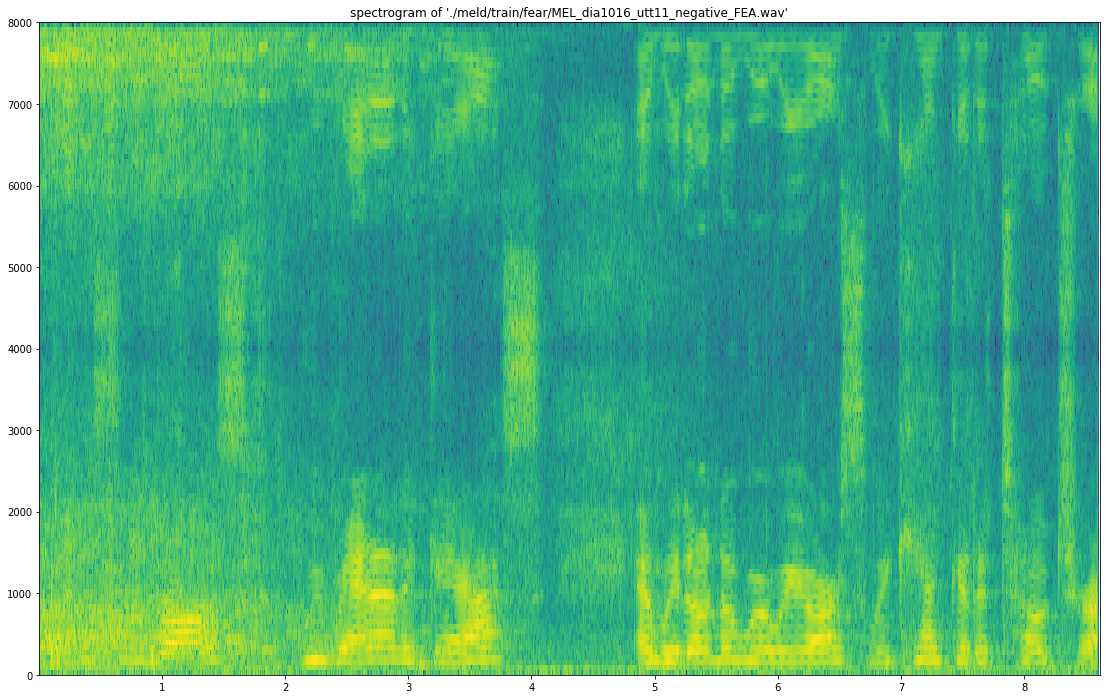

In [8]:
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'Int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

wav_file = './meld/train/fear/MEL_dia1016_utt11_negative_FEA.wav'
graph_spectrogram(wav_file)

ipd.Audio(wav_file)

## Since this is a classification problem, lets take a look at the different classes we have

In [9]:
train_dir_list = os.listdir('./meld/train')
train_dir_list.sort()
train_dir_list

['disgust', 'fear', 'happy', 'neutral', 'sad']

In [10]:
val_dir_list = os.listdir('./meld/val')
val_dir_list.sort()
val_dir_list

['disgust', 'fear', 'happy', 'neutral', 'sad']

## So we will classify a sound file between 'disgust', 'fear', 'happy', 'neutral' and 'sad'

## Everything we do while processing the data will be done with both the train and val folder separately

## After we have done that, we can now append the path of each file into a list and list the class it belongs to

In [0]:
train_path = []
train_emotion = []

for i in train_dir_list:
  fname = os.listdir('./meld/train/' + i)
  for f in fname:
    if i == 'disgust':    
      train_emotion.append('disgust')
    elif i == 'fear':
      train_emotion.append('fear')
    elif i == 'happy':
      train_emotion.append('happy')
    elif i == 'neutral':
      train_emotion.append('neutral')
    elif i == 'sad':
      train_emotion.append('sad') 
    train_path.append('./meld/train/' + i + "/" + f)  

In [0]:
val_path = []
val_emotion = []

for i in val_dir_list:
  fname = os.listdir('./meld/val/' + i)
  for f in fname:
    if i == 'disgust':    
      val_emotion.append('disgust')
    elif i == 'fear':
      val_emotion.append('fear')
    elif i == 'happy':
      val_emotion.append('happy')
    elif i == 'neutral':
       val_emotion.append('neutral')
    elif i == 'sad':
      val_emotion.append('sad') 
    val_path.append('./meld/val/' + i + "/" + f)  

## Using pandas, we will concat the labels and the path into one single DataFrame as well as save those files

In [0]:
train_emotion_df = pd.DataFrame(train_emotion, columns = ['labels'])
train_emotion_df = pd.concat([train_emotion_df,pd.DataFrame(train_path, columns = ['path'])],axis=1)
train_emotion_df.labels.value_counts()
# export_train_csv = train_emotion_df.to_csv(r'./meld/train_emotion_df.csv', index=None, header=True)

In [0]:
val_emotion_df = pd.DataFrame(val_emotion, columns = ['labels'])
val_emotion_df = pd.concat([val_emotion_df,pd.DataFrame(val_path, columns = ['path'])],axis=1)
val_emotion_df.labels.value_counts()
# export_val_csv = val_emotion_df.to_csv(r'./meld/val_emotion_df.csv', index=None, header=True)

### We will now load the data we saved earlier. As a precaution, I will be saving the csv files along the way. This will save time in case of a runtime error.

In [0]:
train_ref = pd.read_csv('./meld/train_emotion_df.csv')
train_ref.head()

,labels,path
0,disgust,./meld/train/disgust/MEL_dia220_utt0_negative_...
1,disgust,./meld/train/disgust/MEL_dia344_utt15_negative...
2,disgust,./meld/train/disgust/MEL_dia471_utt1_negative_...
3,disgust,./meld/train/disgust/MEL_dia482_utt6_negative_...
4,disgust,./meld/train/disgust/MEL_dia992_utt8_negative_...


In [0]:
val_ref = pd.read_csv('./meld/val_emotion_df.csv')
val_ref.head()

,labels,path
0,disgust,./meld/val/disgust/MEL_dia17_utt14_negative_DI...
1,disgust,./meld/val/disgust/MEL_dia17_utt4_negative_DIS...
2,disgust,./meld/val/disgust/MEL_dia41_utt6_negative_DIS...
3,disgust,./meld/val/disgust/MEL_dia21_utt11_negative_DI...
4,disgust,./meld/val/disgust/MEL_dia89_utt12_negative_DI...


## We process files based on their mfcc(s), for this we will use Librosa and extract those features

In [0]:
def extract_mfcc(wav_file_name):
  y, sr = librosa.load(wav_file_name)
  sr = np.array(sr)
  mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
  return mfccs

## Using that function in a loop, we can iterate over each file and extract their mfcc.

In [0]:
train_df = pd.DataFrame(columns=['feature'])

counter=0

for index,path in enumerate(train_ref.path):
    mfccs = extract_mfcc(path)
    train_df.loc[counter] = [mfccs]
    if counter % 100 == 0:
      print(counter)
    counter=counter+1   

print(len(train_df))
train_df.head()

7362


,feature
0,"[-311.1919408648659, 114.97896183309486, -53.5..."
1,"[-283.40692734997606, 125.60971596342166, -55...."
2,"[-189.30583969022916, 160.553146290708, -91.15..."
3,"[-356.34384836500726, 150.12884764657358, -57...."
4,"[-294.9711088272267, 137.8709437287036, -89.66..."


In [0]:
val_df = pd.DataFrame(columns=['feature'])

counter = 0

for index,path in enumerate(val_ref.path):
  mfccs = extract_mfcc(path)
  val_df.loc[counter] = [mfccs]
  # if counter % 100 == 0:
  #   print(counter)
  counter += 1 

print(len(val_df))
val_df.head()

0
100
200
300
400
500
600
700
800
830


,feature
0,"[-318.37160550433634, 128.23730028600673, -41...."
1,"[-252.68330285352607, 121.94046384846912, -78...."
2,"[-446.42634593130623, 108.18838912481998, -34...."
3,"[-345.8462865122208, 162.37525257277161, -86.9..."
4,"[-316.4568153679439, 81.31724606776014, -42.82..."


### Next, we will concat all those feature into a single csv file.

In [0]:
train_df = pd.concat([train_ref,pd.DataFrame(train_df['feature'].values.tolist())],axis=1)
train_df[:5]

,labels,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,disgust,./meld/train/disgust/MEL_dia220_utt0_negative_...,-311.191941,114.978962,-53.504947,29.039773,-34.672663,9.390524,-13.838713,-9.563532,-11.844289,2.976880,-4.851691,-14.180250,0.696510,-6.401932,1.637529,-12.710445,2.910207,-3.878650,-4.993616,-2.599559,-1.429926,-0.706077,-7.559411,3.330141,-3.077321,-0.301846,-3.981192,1.494991,-0.355150,-3.767485,0.702521,-0.454814,0.340205,-3.859025,1.763692,-1.514773,-1.136628,-1.622159,0.264232,-0.836154
1,disgust,./meld/train/disgust/MEL_dia344_utt15_negative...,-283.406927,125.609716,-55.428416,58.291424,-25.455005,29.771236,-19.390048,14.639779,-1.940024,3.410844,3.195646,-4.860951,5.944759,-11.195011,6.499240,-8.405134,6.107248,-7.685190,0.380076,-1.308090,-1.968900,0.650530,-6.464436,4.480281,-5.798970,0.549130,-7.625843,1.330261,-1.344699,-1.252868,-0.919049,-3.328754,2.378156,-3.872897,1.379602,-3.496674,1.390348,-2.470901,0.638559,-0.555664
2,disgust,./meld/train/disgust/MEL_dia471_utt1_negative_...,-189.305840,160.553146,-91.156690,35.535726,-52.241855,6.628765,-34.099085,-11.792016,-19.055635,6.324318,-8.062701,-18.811119,-5.252990,-15.348796,6.054970,-20.994973,-0.838630,-7.215705,-2.075814,-7.678027,-2.098349,0.226036,-8.876239,1.536477,-8.596628,6.096671,-4.712424,1.594258,0.296322,0.570800,-1.088724,-2.653853,3.789995,-5.414757,0.110688,-5.570283,2.267984,-1.093505,-0.935268,1.049000
3,disgust,./meld/train/disgust/MEL_dia482_utt6_negative_...,-356.343848,150.128848,-57.840783,37.487242,-10.089325,3.450059,-22.225181,9.775056,-18.773226,-4.752018,11.303396,-15.431637,2.934551,0.201039,2.216667,-3.748066,4.725012,-7.477359,-0.799107,0.547701,-3.327642,0.943222,-4.611599,5.274373,-4.427122,-5.443484,-1.791148,-0.878861,-8.117096,-0.816837,0.663175,-7.578019,0.642866,-0.495204,-0.682442,-2.061412,5.296668,1.226637,-1.430871,3.219904
4,disgust,./meld/train/disgust/MEL_dia992_utt8_negative_...,-294.971109,137.870944,-89.662701,56.190387,-32.127111,-10.779783,-6.881448,2.467585,-4.585748,1.363688,-3.591070,-5.669435,-11.399943,-13.280163,1.943307,-15.418287,-0.073504,-11.799257,-2.221179,-2.843811,0.441499,1.971158,-5.930422,7.288592,-1.347973,10.698074,1.178008,4.165836,4.566314,-1.570827,0.674014,-5.342293,2.405415,0.090655,2.722499,-0.303393,-0.944513,2.641939,1.532699,-3.337901


In [0]:
val_df = pd.concat([val_ref,pd.DataFrame(val_df['feature'].values.tolist())],axis=1)
val_df[:5]

,labels,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,disgust,./meld/val/disgust/MEL_dia17_utt14_negative_DI...,-318.371606,128.237300,-41.038733,44.957109,-40.328523,20.093434,-27.444436,-0.099432,-9.658646,-6.867474,-3.980732,-5.860197,6.644731,-12.885594,9.318297,-2.815127,4.701263,-4.247807,3.492561,0.291716,-4.076636,2.440389,-5.096545,2.734505,-5.972748,1.254003,-5.315545,-3.990067,-3.201267,-3.351245,-1.774948,-4.036731,-4.687929,-6.434125,-1.083636,-4.925192,2.510029,-4.242066,-2.281044,-0.877720
1,disgust,./meld/val/disgust/MEL_dia17_utt4_negative_DIS...,-252.683303,121.940464,-78.553463,34.055831,-61.470263,0.788583,-26.362780,-4.010653,-20.779624,-12.920987,-6.417492,-3.451289,15.097963,-9.482047,7.656775,-1.217949,1.217373,-5.563299,2.724393,-5.672596,-3.601987,-3.886564,-14.350575,-2.497948,-12.018996,-1.739630,-6.616604,2.045189,3.570908,7.320307,13.870410,0.914678,-0.318267,-2.820042,-1.180224,-0.028984,6.779493,-1.184259,0.298372,1.471622
2,disgust,./meld/val/disgust/MEL_dia41_utt6_negative_DIS...,-446.426346,108.188389,-34.602381,43.260125,-30.506438,21.311157,-6.799303,10.679865,-5.019371,5.140439,2.955350,-8.408062,3.125687,-8.170161,4.697499,-9.116650,2.319287,-6.488215,-0.575134,-2.026754,-4.122335,-1.357810,-7.386168,3.654327,-3.246251,3.966022,0.590204,2.131880,-0.875146,1.100464,-0.176957,-2.912033,3.717331,-3.177480,1.052208,-1.744346,-0.823797,-2.957974,-0.046909,-1.326202
3,disgust,./meld/val/disgust/MEL_dia21_utt11_negative_DI...,-345.846287,162.375253,-86.961952,26.083801,-24.554182,8.427949,-23.383850,5.505741,-11.179727,-4.958285,-5.178874,-7.907623,-4.161175,-13.261966,7.622504,-16.713130,2.289727,-8.023629,-4.655298,-4.316351,-4.158037,3.386849,-7.016956,8.081415,-4.852263,1.451419,-2.097524,-1.083750,1.868394,-2.194422,-2.509160,-6.020438,1.640201,0.362873,0.520219,-5.921690,-0.452166,-2.326508,-4.188774,-3.025399
4,disgust,./meld/val/disgust/MEL_dia89_utt12_negative_DI...,-316.456815,81.317246,-42.820428,59.068725,-41.922629,31.106853,-32.684857,15.879272,-12.609518,-0.488443,-4.311494,-7.019880,8.540193,-12.024010,11.456297,-12.263217,12.357340,-0.955493,9.482329,2.035310,-4.265326,-4.154588,-9.792159,5.064971,-3.118300,10.654609,-3.714842,3.884013,-0.790474,-1.026155,-2.651259,-7.505931,0.207063,-3.753146,1.785343,-4.793981,1.379708,-0.972597,1.895048,-1.765519


## In case there are any empty values in the array, we can use fillna function to fill it as 0(silence) so that it cannot influence the dataset

In [0]:
# train_df = train_df.fillna(0)
# print(train_df.shape)
# train_df[:5]

In [0]:
# val_df = val_df.fillna(0)
# print(val_df.shape)
# val_df[:5]

## Saving these files since processing apparently takes more time than training.

In [0]:
# export_training_csv = train_df.to_csv(r'./meld/train1_df.csv', index=None, header=True)
# export_validation_csv = val_df.to_csv(r'./meld/val1_df.csv', index=None, header=True)

## Loading these files at this point

In [0]:
train_df_1 = pd.read_csv('./meld/train1_df.csv')

In [14]:
train_df_1.head()

,labels,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,disgust,./meld/train/disgust/MEL_dia220_utt0_negative_...,-311.191941,114.978962,-53.504947,29.039773,-34.672663,9.390524,-13.838713,-9.563532,-11.844289,2.976880,-4.851691,-14.180250,0.696510,-6.401932,1.637529,-12.710445,2.910207,-3.878650,-4.993616,-2.599559,-1.429926,-0.706077,-7.559411,3.330141,-3.077321,-0.301846,-3.981192,1.494991,-0.355150,-3.767485,0.702521,-0.454814,0.340205,-3.859025,1.763692,-1.514773,-1.136628,-1.622159,0.264232,-0.836154
1,disgust,./meld/train/disgust/MEL_dia344_utt15_negative...,-283.406927,125.609716,-55.428416,58.291424,-25.455005,29.771236,-19.390048,14.639779,-1.940024,3.410844,3.195646,-4.860951,5.944759,-11.195011,6.499240,-8.405134,6.107248,-7.685190,0.380076,-1.308090,-1.968900,0.650530,-6.464436,4.480281,-5.798970,0.549130,-7.625843,1.330261,-1.344699,-1.252868,-0.919049,-3.328754,2.378156,-3.872897,1.379602,-3.496674,1.390348,-2.470901,0.638559,-0.555664
2,disgust,./meld/train/disgust/MEL_dia471_utt1_negative_...,-189.305840,160.553146,-91.156690,35.535726,-52.241855,6.628765,-34.099085,-11.792016,-19.055635,6.324318,-8.062701,-18.811119,-5.252990,-15.348796,6.054970,-20.994973,-0.838630,-7.215705,-2.075814,-7.678027,-2.098349,0.226036,-8.876239,1.536477,-8.596628,6.096671,-4.712424,1.594258,0.296322,0.570800,-1.088724,-2.653853,3.789995,-5.414757,0.110688,-5.570283,2.267984,-1.093505,-0.935268,1.049000
3,disgust,./meld/train/disgust/MEL_dia482_utt6_negative_...,-356.343848,150.128848,-57.840783,37.487242,-10.089325,3.450059,-22.225181,9.775056,-18.773226,-4.752018,11.303396,-15.431637,2.934551,0.201039,2.216667,-3.748066,4.725012,-7.477359,-0.799107,0.547701,-3.327642,0.943222,-4.611599,5.274373,-4.427122,-5.443484,-1.791148,-0.878861,-8.117096,-0.816837,0.663175,-7.578019,0.642866,-0.495204,-0.682442,-2.061412,5.296668,1.226637,-1.430871,3.219904
4,disgust,./meld/train/disgust/MEL_dia992_utt8_negative_...,-294.971109,137.870944,-89.662701,56.190387,-32.127111,-10.779783,-6.881448,2.467585,-4.585748,1.363688,-3.591070,-5.669435,-11.399943,-13.280163,1.943307,-15.418287,-0.073504,-11.799257,-2.221179,-2.843811,0.441499,1.971158,-5.930422,7.288592,-1.347973,10.698074,1.178008,4.165836,4.566314,-1.570827,0.674014,-5.342293,2.405415,0.090655,2.722499,-0.303393,-0.944513,2.641939,1.532699,-3.337901


In [0]:
val_df_1 = pd.read_csv('./meld/val1_df.csv')

In [17]:
val_df_1.head()

,labels,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,disgust,./meld/val/disgust/MEL_dia17_utt14_negative_DI...,-318.371606,128.237300,-41.038733,44.957109,-40.328523,20.093434,-27.444436,-0.099432,-9.658646,-6.867474,-3.980732,-5.860197,6.644731,-12.885594,9.318297,-2.815127,4.701263,-4.247807,3.492561,0.291716,-4.076636,2.440389,-5.096545,2.734505,-5.972748,1.254003,-5.315545,-3.990067,-3.201267,-3.351245,-1.774948,-4.036731,-4.687929,-6.434125,-1.083636,-4.925192,2.510029,-4.242066,-2.281044,-0.877720
1,disgust,./meld/val/disgust/MEL_dia17_utt4_negative_DIS...,-252.683303,121.940464,-78.553463,34.055831,-61.470263,0.788583,-26.362780,-4.010653,-20.779624,-12.920987,-6.417492,-3.451289,15.097963,-9.482047,7.656775,-1.217949,1.217373,-5.563299,2.724393,-5.672596,-3.601987,-3.886564,-14.350575,-2.497948,-12.018996,-1.739630,-6.616604,2.045189,3.570908,7.320307,13.870410,0.914678,-0.318267,-2.820042,-1.180224,-0.028984,6.779493,-1.184259,0.298372,1.471622
2,disgust,./meld/val/disgust/MEL_dia41_utt6_negative_DIS...,-446.426346,108.188389,-34.602381,43.260125,-30.506438,21.311157,-6.799303,10.679865,-5.019371,5.140439,2.955350,-8.408062,3.125687,-8.170161,4.697499,-9.116650,2.319287,-6.488215,-0.575134,-2.026754,-4.122335,-1.357810,-7.386168,3.654327,-3.246251,3.966022,0.590204,2.131880,-0.875146,1.100464,-0.176957,-2.912033,3.717331,-3.177480,1.052208,-1.744346,-0.823797,-2.957974,-0.046909,-1.326202
3,disgust,./meld/val/disgust/MEL_dia21_utt11_negative_DI...,-345.846287,162.375253,-86.961952,26.083801,-24.554182,8.427949,-23.383850,5.505741,-11.179727,-4.958285,-5.178874,-7.907623,-4.161175,-13.261966,7.622504,-16.713130,2.289727,-8.023629,-4.655298,-4.316351,-4.158037,3.386849,-7.016956,8.081415,-4.852263,1.451419,-2.097524,-1.083750,1.868394,-2.194422,-2.509160,-6.020438,1.640201,0.362873,0.520219,-5.921690,-0.452166,-2.326508,-4.188774,-3.025399
4,disgust,./meld/val/disgust/MEL_dia89_utt12_negative_DI...,-316.456815,81.317246,-42.820428,59.068725,-41.922629,31.106853,-32.684857,15.879272,-12.609518,-0.488443,-4.311494,-7.019880,8.540193,-12.024010,11.456297,-12.263217,12.357340,-0.955493,9.482329,2.035310,-4.265326,-4.154588,-9.792159,5.064971,-3.118300,10.654609,-3.714842,3.884013,-0.790474,-1.026155,-2.651259,-7.505931,0.207063,-3.753146,1.785343,-4.793981,1.379708,-0.972597,1.895048,-1.765519


In [0]:
# train_df_1 = train_df;
# train_df_1.head()

In [0]:
# val_df_1 = val_df;
# val_df_1.head()

## This is the pivotal point in the code. Please read the following:
------------------------------------------------------
*   Since this code is already distributed into train and val, we need to combine it to noramlize or even out the number of files available for training and testing.
*   Number of reasons support this logic. 
We saw above that the number of files for each emotion in train does not correspong to the number of files in val.


*   This means that there is no equal distribution in those files.





## Due to those above reasons, I combined the data of train and val folders

In [76]:
final_df = pd.concat([train_df_1, val_df_1], ignore_index=True, axis=0)
final_df.head()

,labels,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,disgust,./meld/train/disgust/MEL_dia220_utt0_negative_...,-311.191941,114.978962,-53.504947,29.039773,-34.672663,9.390524,-13.838713,-9.563532,-11.844289,2.976880,-4.851691,-14.180250,0.696510,-6.401932,1.637529,-12.710445,2.910207,-3.878650,-4.993616,-2.599559,-1.429926,-0.706077,-7.559411,3.330141,-3.077321,-0.301846,-3.981192,1.494991,-0.355150,-3.767485,0.702521,-0.454814,0.340205,-3.859025,1.763692,-1.514773,-1.136628,-1.622159,0.264232,-0.836154
1,disgust,./meld/train/disgust/MEL_dia344_utt15_negative...,-283.406927,125.609716,-55.428416,58.291424,-25.455005,29.771236,-19.390048,14.639779,-1.940024,3.410844,3.195646,-4.860951,5.944759,-11.195011,6.499240,-8.405134,6.107248,-7.685190,0.380076,-1.308090,-1.968900,0.650530,-6.464436,4.480281,-5.798970,0.549130,-7.625843,1.330261,-1.344699,-1.252868,-0.919049,-3.328754,2.378156,-3.872897,1.379602,-3.496674,1.390348,-2.470901,0.638559,-0.555664
2,disgust,./meld/train/disgust/MEL_dia471_utt1_negative_...,-189.305840,160.553146,-91.156690,35.535726,-52.241855,6.628765,-34.099085,-11.792016,-19.055635,6.324318,-8.062701,-18.811119,-5.252990,-15.348796,6.054970,-20.994973,-0.838630,-7.215705,-2.075814,-7.678027,-2.098349,0.226036,-8.876239,1.536477,-8.596628,6.096671,-4.712424,1.594258,0.296322,0.570800,-1.088724,-2.653853,3.789995,-5.414757,0.110688,-5.570283,2.267984,-1.093505,-0.935268,1.049000
3,disgust,./meld/train/disgust/MEL_dia482_utt6_negative_...,-356.343848,150.128848,-57.840783,37.487242,-10.089325,3.450059,-22.225181,9.775056,-18.773226,-4.752018,11.303396,-15.431637,2.934551,0.201039,2.216667,-3.748066,4.725012,-7.477359,-0.799107,0.547701,-3.327642,0.943222,-4.611599,5.274373,-4.427122,-5.443484,-1.791148,-0.878861,-8.117096,-0.816837,0.663175,-7.578019,0.642866,-0.495204,-0.682442,-2.061412,5.296668,1.226637,-1.430871,3.219904
4,disgust,./meld/train/disgust/MEL_dia992_utt8_negative_...,-294.971109,137.870944,-89.662701,56.190387,-32.127111,-10.779783,-6.881448,2.467585,-4.585748,1.363688,-3.591070,-5.669435,-11.399943,-13.280163,1.943307,-15.418287,-0.073504,-11.799257,-2.221179,-2.843811,0.441499,1.971158,-5.930422,7.288592,-1.347973,10.698074,1.178008,4.165836,4.566314,-1.570827,0.674014,-5.342293,2.405415,0.090655,2.722499,-0.303393,-0.944513,2.641939,1.532699,-3.337901


In [77]:
final_df.tail()

,labels,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
8187,sad,./meld/val/sad/MEL_dia78_utt0_negative_SAD.wav,-441.030206,112.974562,-27.264009,56.170539,-28.862971,23.959384,-15.196725,2.973322,-13.782626,-3.466343,0.473670,-10.186469,1.896602,-10.670946,3.449792,-8.132878,4.876137,-6.356624,-1.351464,-4.645780,-3.905907,2.012971,-5.816349,3.473416,-6.193964,3.530996,-3.400670,-1.311796,-0.257451,0.596213,1.029341,-2.689950,0.958075,-6.142693,1.060555,-2.604805,0.413723,-0.419738,-0.612008,-0.653700
8188,sad,./meld/val/sad/MEL_dia63_utt5_negative_SAD.wav,-303.843662,128.577240,-53.647525,51.037727,-41.545882,17.733752,-20.983585,3.976225,-13.888878,9.074178,3.698947,-8.863689,6.795530,-13.883288,7.243410,-9.194729,1.491187,-6.197794,2.112873,-3.478754,-1.263412,4.003179,-5.527431,5.166621,-4.615676,5.208369,-0.878229,2.854456,-2.571157,-2.311590,-0.149054,-3.862080,2.279520,-2.105721,2.642290,-0.830744,3.121286,-0.823149,-1.391399,-2.529791
8189,sad,./meld/val/sad/MEL_dia84_utt5_negative_SAD.wav,-222.763122,147.055539,-89.469913,41.536735,-46.378078,24.591755,-23.140845,4.876909,-15.860891,7.576709,1.473999,-8.687744,6.819279,-13.428055,8.457088,-12.764394,2.465637,-10.630944,0.141398,-3.950443,-5.221237,-1.249704,-7.667530,3.491583,-5.338383,5.786413,-4.950278,1.889959,-2.199494,-0.933589,-0.948088,-1.817937,2.456899,-4.750002,1.044888,-5.468356,0.745077,-1.862301,2.458543,-0.443458
8190,sad,./meld/val/sad/MEL_dia6_utt16_negative_SAD.wav,-245.405594,98.220223,-56.595650,59.127818,-52.821633,29.930903,-13.265096,14.197942,-7.696976,8.732932,-5.617118,-3.384614,11.863263,-14.472294,10.535975,-10.113260,4.253741,-5.524077,8.069201,-4.690323,-5.278089,-0.596390,-11.134754,0.673078,-3.109973,10.232395,4.083220,14.348018,4.444491,-0.251800,-1.824642,-2.523807,0.753359,-0.180612,1.904127,-7.979725,-0.269763,-1.471016,3.247051,-1.772454
8191,sad,./meld/val/sad/MEL_dia50_utt7_negative_SAD.wav,-289.252137,138.138877,-40.356475,46.903919,-40.536254,9.737397,-34.610332,8.504609,-7.000750,-8.293560,-4.814148,-9.418478,4.525665,-17.761514,6.763541,-7.121133,-0.639672,-3.516564,-5.111330,-6.029048,-1.786085,-2.838648,-5.441482,0.776951,-9.501633,1.740945,-10.974579,-1.814891,-2.883392,-5.187603,5.744501,1.943556,7.562787,7.634524,7.399606,-0.754494,3.407263,1.450448,2.262608,1.857637


## Now that we have a final data csv file, we can use train_test_split to divide the data and shuffle it as well. I would like to remind that the data is ordered, so do not proceed without shuffling as it would give really low results further on.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(['path','labels'],axis=1), final_df.labels, test_size=0.25, shuffle=True, random_state=42)

X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
4407,-421.138698,123.913465,-24.559578,41.612601,-29.622018,30.237048,-17.924358,6.630622,-5.484437,0.634764,5.098799,0.535349,8.056023,-9.730494,13.616859,-7.863318,-4.416711,-9.129963,2.577748,2.901615,-5.198286,-0.243000,-5.754470,0.642488,-9.821859,-3.067553,-9.515720,-1.977855,-3.277610,-5.035569,0.375335,-7.332216,-3.785588,-3.843634,4.272669,-0.930878,3.207597,2.573315,-1.255488,-0.948792
6462,-280.614440,136.678156,-46.964279,65.648407,-27.807668,25.010328,-19.234766,5.378361,-17.094806,-0.534460,7.415894,1.161239,9.374648,-18.215089,-1.061604,-10.985468,-3.329350,-13.188828,0.284168,-5.132856,-2.938711,1.086516,-7.839866,2.395744,-5.999934,1.310795,-9.905168,-5.920110,-6.082320,-1.998827,-3.386101,-3.440697,0.835183,-6.939615,0.304162,-4.474985,0.675329,-3.524882,-0.423695,-2.344128
4862,-313.392631,121.700112,-53.694382,48.975333,-36.553657,27.351551,-27.057317,7.885990,-15.746917,-1.060529,-0.550321,-7.231002,6.371524,-4.281680,16.504943,-8.854403,12.711654,-3.175289,2.289527,-2.158604,-2.036807,4.792083,-5.795862,5.901760,-6.323998,0.625656,-9.921598,-3.110151,-3.509611,-2.041974,-1.158926,-4.247096,1.977379,-4.053881,1.996346,-2.921535,0.080013,-2.632441,0.569508,-1.500770
2910,-320.538935,145.123430,-65.173144,52.704643,-37.295997,12.302146,-22.141827,-4.521276,-18.041127,0.095103,-4.937945,-11.087443,3.205398,-11.126686,6.516422,-16.404531,0.445009,-8.847883,-2.706033,-4.645283,-3.742383,2.733056,-8.763613,4.473835,-8.331625,0.420515,-2.877278,-1.456718,-1.892157,-0.786810,2.615489,-2.451606,1.451842,-3.705854,0.496083,-2.744575,0.452618,-1.047656,-0.300965,-1.438140
5916,-483.382293,129.693092,-10.856966,36.464395,-18.655967,24.825821,0.958292,4.129662,-10.036026,-4.658906,-5.222601,-7.306424,-0.164738,-16.087406,2.112736,-6.472578,-3.654578,-7.344886,1.825713,-6.888660,-14.866322,1.030125,-10.778727,-4.321370,0.477533,-0.892021,-11.281435,-9.284955,-3.093272,-7.362843,-8.434784,-4.260479,-1.808422,-4.548943,-1.617449,-3.738600,0.088550,-5.427246,2.026146,4.858776
3842,-358.993258,140.446081,-22.429034,58.268749,-21.000571,32.086181,-15.681571,20.459817,-4.507265,-5.050278,-4.124735,-11.635067,-1.477395,-12.383932,6.474685,-14.597873,0.176389,-10.968475,-1.442167,-2.746674,-2.767950,3.060052,-4.858619,8.710503,-4.332924,1.159314,-6.378663,-5.029527,-8.623172,-5.668347,-0.557925,-3.848083,2.917898,-0.031430,4.198498,-1.658778,0.979496,-4.000394,-3.660126,-4.490364
7865,-349.719026,122.298504,-40.547456,51.004311,-32.179032,18.599089,-25.913910,15.853260,0.433025,2.550411,2.350426,-4.346564,2.007284,-7.539187,8.191549,-12.474674,6.624157,-5.317740,1.823327,-2.686852,-1.609262,3.694597,-4.643639,3.616976,-7.520698,0.201680,-7.044614,-0.254601,-1.038495,-1.139231,-2.287777,-0.123612,2.356675,-2.399750,6.473936,-1.649687,4.017953,-0.707715,0.309886,0.655670
5995,-374.802185,128.722635,-12.337438,41.926312,-19.959336,21.447200,-9.175362,12.877193,-3.775916,1.913925,1.059977,-8.256609,2.840474,-10.142685,5.628520,-8.621958,-1.832446,-3.507299,-0.463369,-3.983779,-3.044962,2.188634,-4.487542,2.885325,-5.564002,-1.166506,-3.462188,-3.403880,-5.292956,-2.152480,-1.174206,-3.782669,1.009906,-1.154447,2.731894,-0.245715,2.780773,-0.598150,-1.305202,-0.639162
3666,-363.235126,117.000547,-42.624218,48.766224,-18.837956,19.407104,-19.710113,6.929715,-18.178917,0.957424,-1.313603,-13.744942,-0.441370,-14.015719,9.496735,-5.910256,1.186543,-2.308514,4.346923,-5.348717,-2.793415,4.347165,-5.619338,-0.396428,-0.548086,6.415789,-9.292949,-2.598091,-7.534165,-8.421659,-3.700995,-4.389245,-0.395289,-4.328164,2.242930,0.360737,4.423446,-1.701098,-0.879761,-1.395683
6942,-411.017779,111.985711,-57.438100,48.925874,-40.067606,38.571865,-23.830950,8.151773,-14.205614,-0.725032,-4.564833,-9.560672,9.259680,-0.687878,20.010908,-5.087989,10.457029,-4.539701,7.606265,0.158830,2.467538,7.052348,-3.356298,8.461540,-7.161098,1.641809,

## Looking at the data, we can see that while there are numbers like 421.1368 there are other values like 10. To reduce this kind of difference in values, we will normalize it using mean of the values

In [79]:
# Lets do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
4407,-1.417415,-0.180695,1.312682,-0.387836,0.192286,1.315885,0.264571,0.391912,0.737147,0.154234,1.346884,1.711467,1.147105,0.051877,1.552220,0.494022,-1.572500,-0.796722,0.357067,1.343490,-0.555397,-0.449551,-0.029530,-0.675828,-1.078202,-1.578640,-1.476295,-0.491684,-0.305408,-1.018051,0.173056,-1.567934,-1.965611,-0.303584,0.859183,0.605559,0.790702,1.749447,-0.384184,-0.132274
6462,0.759957,0.513290,0.136371,1.657588,0.357637,0.765432,0.098015,0.229845,-1.221496,-0.057369,1.797911,1.841189,1.425130,-1.814324,-1.800362,-0.117474,-1.339284,-1.805850,-0.213554,-0.720744,0.040236,-0.075779,-0.608402,-0.199171,0.044292,-0.292321,-1.594578,-1.669469,-1.184338,-0.036165,-1.086926,-0.241931,-0.305735,-1.430994,-0.644001,-0.777831,-0.229523,-0.773896,-0.030130,-0.733194
4862,0.252071,-0.301030,-0.216979,0.238726,-0.439426,1.011998,-0.896247,0.554382,-0.994110,-0.152576,0.247271,0.101821,0.791937,1.250353,2.211862,0.299911,2.101175,0.683749,0.285360,0.043407,0.277982,0.965981,-0.041019,0.754008,-0.050885,-0.493609,-1.599568,-0.829968,-0.378112,-0.050116,-0.340881,-0.516705,0.104565,-0.380147,-0.003038,-0.171464,-0.469370,-0.404617,0.392629,-0.369990
2910,0.141341,0.972439,-0.819647,0.556086,-0.507079,-0.572931,-0.271478,-1.051365,-1.381138,0.056567,-0.606789,-0.697461,0.124376,-0.255218,-0.069530,-1.178838,-0.529763,-0.726590,-0.957487,-0.595476,-0.171615,0.387119,-0.864820,0.365798,-0.640522,-0.553877,0.539933,-0.335989,0.128760,0.355723,0.923448,0.095093,-0.084219,-0.253412,-0.571305,-0.102391,-0.319251,0.251144,0.022110,-0.343018
5916,-2.381857,0.133529,2.032109,-0.825943,1.191674,0.746001,2.664596,0.068238,-0.030695,-0.803800,-0.662198,0.086189,-0.586200,-1.346336,-1.075338,0.766409,-1.409038,-0.352910,0.169968,-1.171850,-3.103932,-0.091632,-1.424183,-2.025350,1.946716,-0.939488,-2.012578,-2.674748,-0.247641,-1.770541,-2.778101,-0.521266,-1.255373,-0.560425,-1.371865,-0.490393,-0.465931,-1.561065,1.012650,2.368835
3842,-0.454494,0.718143,1.424542,1.029586,0.977999,1.510626,0.549634,2.181685,0.901994,-0.874630,-0.448496,-0.810962,-0.862967,-0.531751,-0.079063,-0.824991,-0.587377,-1.253818,-0.643049,-0.107681,0.085250,0.479049,0.219144,1.517620,0.533891,-0.336825,-0.523508,-1.403399,-1.980581,-1.222651,-0.139561,-0.380745,0.442419,1.084640,0.831089,0.321434,-0.106978,-0.970655,-1.407724,-1.657500
7865,-0.310793,-0.268497,0.473273,0.411390,-0.040746,0.090232,-0.750918,1.585505,1.735410,0.500922,0.811907,0.699647,-0.128240,0.533859,0.313071,-0.409146,0.795535,0.151086,0.169374,-0.092312,0.390685,0.657441,0.278820,0.132844,-0.402354,-0.618169,-0.725770,0.023154,0.396278,0.241773,-0.719016,0.888337,0.240816,0.222210,1.692976,0.324983,1.117187,0.391806,0.282120,0.558710
5995,-0.699448,0.080768,1.954380,-0.361139,1.072892,0.390181,1.376587,1.200343,1.025371,0.385733,0.560719,-0.110745,0.047434,-0.038785,-0.272328,0.345437,-1.018230,0.601203,-0.399534,-0.425521,0.012228,0.234064,0.322150,-0.066069,0.172325,-1.020130,0.362284,-0.917722,-0.936970,-0.085846,-0.345999,-0.358456,-0.242971,0.675690,0.275571,0.873003,0.618739,0.437143,-0.405345,0.001073
3666,-0.520220,-0.556534,0.364237,0.220931,1.175088,0.175328,0.037598,0.430621,-1.404383,0.212628,0.098697,-1.248252,-0.644526,-0.890666,0.611178,0.876544,-0.370720,0.899249,0.797220,-0.776204,0.078537,0.840900,0.007981,-0.958278,1.645493,1.207479,-1.408635,-0.676985,-1.639312,-2.112894,-1.192407,-0.565142,-0.747746,-0.480028,0.090363,1.109722,1.280556,-0.019241,-0.224255,-0.324733
6942,-1.260595,-0.829178,-0.413535,0.234517,-0.759669,2.193666,-0.486169,0.588779,-0.734095,-0.091859,-0.534162,-0.381024,1.400890,2.040815,3.012629,1.037591,1.617605,0.344524,1.608113,0.638808,1.465346,1.601418,0.636165,1.449934,-0.296740,-0.195072,-0.148555,-0.258934,-0.425710,-0.546911,-2.637610,-1.405247,-1.061055,-0.041889,0.247991,-0.973218,0.625884,-0.195676,0.283162,0.019348


## Preprocessing of the data before feeding it into the network
*  We will use LabelEncoder, to transform the classes from string into int

In [80]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(6144, 40)
['disgust' 'fear' 'happy' 'neutral' 'sad']


In [0]:
X_test

In [81]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(6144, 40, 1)

## Finally we have reached the modelling phase of this code.
## We will use Conv1D to get better results.

In [82]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 8, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(3)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(5)) # Target class number
model.add(Activation('softmax'))

opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 40, 256)           2304      
_________________________________________________________________
activation_65 (Activation)   (None, 40, 256)           0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 40, 256)           524544    
_________________________________________________________________
batch_normalization_8 (Batch (None, 40, 256)           1024      
_________________________________________________________________
activation_66 (Activation)   (None, 40, 256)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 40, 256)           0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 5, 256)          

### This time we will use the SGD optimizer this time. 
### The other optimizers are listed above as well.

### Time to train!!!

In [83]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Train on 6144 samples, validate on 2048 samples
Epoch 1/50
6144/6144 [==============================] - 7s 1ms/step - loss: 1.5589 - acc: 0.3730 - val_loss: 1.4006 - val_acc: 0.6196
Epoch 2/50
6144/6144 [==============================] - 6s 897us/step - loss: 1.2333 - acc: 0.6263 - val_loss: 1.2665 - val_acc: 0.6196
Epoch 3/50
6144/6144 [==============================] - 5s 886us/step - loss: 1.1485 - acc: 0.6263 - val_loss: 1.2138 - val_acc: 0.6196
Epoch 4/50
6144/6144 [==============================] - 5s 885us/step - loss: 1.1198 - acc: 0.6263 - val_loss: 1.1908 - val_acc: 0.6196
Epoch 5/50
6144/6144 [==============================] - 5s 888us/step - loss: 1.1075 - acc: 0.6263 - val_loss: 1.1816 - val_acc: 0.6196
Epoch 6/50
6144/6144 [==============================] - 6s 920us/step - loss: 1.0987 - acc: 0.6263 - val_loss: 1.1687 - val_acc: 0.6196
Epoch 7/50
6144/6144 [==============================] - 6s 921us/step - loss: 1.0928 - acc: 0.6263 - val_loss: 1.1646 - val_acc: 0.6196
Ep

### We got the results and since I dont have any previous metrics on this data, I cannot how it performed.
### Using SGD gave me better results, compared to other optimizers

### Lets visualize the perfomance and the loss

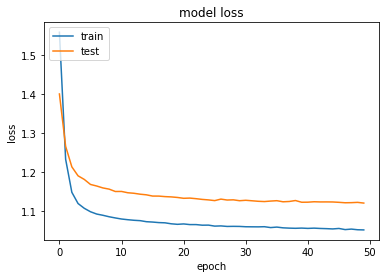

In [85]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### As we can see, the loss reduced exponentially for both training and testing

### Saving the model for use it again without retraining 

In [86]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
  json_file.write(model_json)

Save model and weights at /content/drive/My Drive/Emotions/saved_models/Emotion_Model.h5 


### Loading our trained model

In [87]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 61.91%


### Getting the predicted values

In [88]:
preds = loaded_model.predict(X_test, batch_size=16, verbose=1)

preds=preds.argmax(axis=1)
preds

2048/2048 [==============================] - 1s 451us/step


array([3, 3, 3, ..., 3, 3, 3])

### Comparing it the predicted to the actual values

In [89]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
print(finaldf)

     actualvalues predictedvalues
0         neutral         neutral
1         neutral         neutral
2         neutral         neutral
3             sad         neutral
4         neutral         neutral
...           ...             ...
2043         fear         neutral
2044      neutral         neutral
2045      neutral         neutral
2046          sad         neutral
2047      neutral         neutral

[2048 rows x 2 columns]


## Saving the predictions in a CSV file

In [95]:
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
happy,2
neutral,2046


## Finding the heatmap of the actual and predicted values

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
  )
  fig = plt.figure(figsize=figsize)
  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
      
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


0.619140625


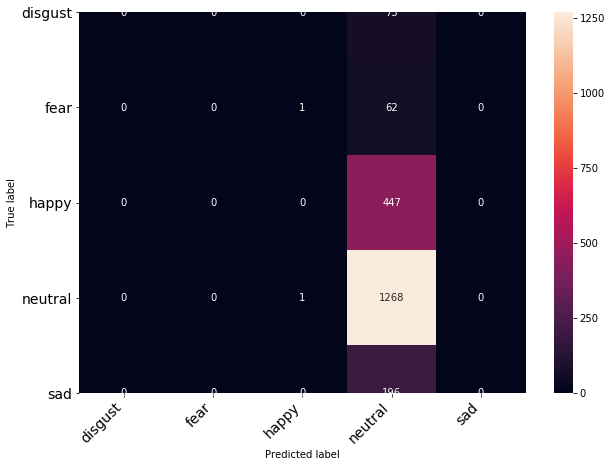

In [97]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

## The reason for these types of predictions will be discussed in the conclusion. 

# Conclusion(Important):


*   We find that the predicted values consists of only two classes.
*   This code has been checked over again. The only reason I could find for this type of behaviour is the number of files of each class. This dataset consists of 8192 files.


*   The number of files for "neutral" alone is 5117.
*   That is more than 50% in a dataset consisting of 5 classes.

*   Second most occuring class is "happy" with 1790 files which is still very less compared to neutral.
*   Due to this bias in the data, we can assume that the results are deviated towards predicting neutral almost all of the time.  







### Author: Amarpreet Singh